# MARS computer

This notebook accompanies the paper "Maximal Atomic Redundancy-free Sets: a Usage-based Dataflow Partitioning 
Algorithm" submitted at IMPACT'23.

In this notebook, we construct the MARS for various applications given:
* an iteration space,
* a dependence pattern (PRDG),
* tiling hyperplanes and their normal vectors,
* tile sizes,
* (for visualization) The iteration space for 2-D iteration spaces, and a sample tile of interest for 3D iteration spaces.

To run this notebook, you must have the following Python packages:
* `matplotlib`
* `numpy`
* `islpy`
* `islplot`(https://github.com/tobiasgrosser/islplot)

All of these packages are available through PIP, except `islplot` that can be installed from the provided link.

In [1]:
# Plotting functions

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.ticker as mticker

import pylab as pl
import numpy

from islplot.support import *
import islplot.plotter as islp
from islpy import *

import colorsys

# The code below is for 3-D visualization of ISL sets.
# It is a derivative from ISLPlot (https://github.com/tobiasgrosser/islplot) using Matplotlib.
#
# ISLPlot license:
#
# MIT license
# 
# Copyright (c) 2014 Tobias Grosser
# 
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the
# "Software"), to deal in the Software without restriction, including
# without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to
# permit persons to whom the Software is furnished to do so, subject to
# the following conditions:
# 
# The above copyright notice and this permission notice shall be included
# in all copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS
# OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
# MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
# IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY
# CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,
# TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
# SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

def mpy_list_scalar(l, x):
    return [x * i for i in l]
    
def float_list_to_rgb_string(fl):
    scaled = mpy_list_scalar(fl, 255.0)
    hex_str = ['{:02x}'.format(int(i)) for i in scaled]
    w = "".join(hex_str)
    
    return "#" + w

def plot_points(ax, points, color, size):
    xs = list([point[0] for point in points])
    ys = list([point[1] for point in points])
    zs = list([point[2] for point in points])
    ax.scatter(xs, ys, zs, c=color, s=size)
    
def plot_bset_3d_points(ax, bset_data, only_hull, color, size):
    """
    Plot the individual points of a three dimensional isl basic set.
    :param bset_data: The islpy.BasicSet to plot.
    :param only_hull: Only plot the points on the hull of the basic set.
    """
    bset_data = bset_data.convex_hull()
    #color = colors[0]['light']
    points = bset_get_points(bset_data, only_hull)
    plot_points(ax, points, color, size)

def plot_set_3d_vertices(ax, vertices, color):
    # color = colors[0]['dark']
    plot_points(ax, vertices, color, 8.0)

def plot_set_3d_shape(ax, vertices, faces, show_border, color, alpha):
    #color = colors[0]['base']
    
    for f in faces:
        vertices_in_order = []
        for p in f:
            vertices_in_order.append(vertices[p])
        tri = art3d.Poly3DCollection([vertices_in_order])
        tri.set_facecolor(color)
        #tri.set_alpha(alpha)
        if show_border:
            tri.set_edgecolor('k')
        ax.add_collection3d(tri)

def plot_set_3d(sets_data, fig=None, alpha=0.3, show_vertices=True, show_points=True,
        show_shape=True, show_border=True, only_hull_points=True, face_colors=None, face_alpha=None, 
                points_size=1.0, points_color="#000000"):
    """
    This function plots a three dimensional convex set.
    :param set_data: The set to illustrate.
    :param show_vertices: Show the vertices at the corner of the set.
    :param show_points: Show the full integer points contained in the set.
    :param show_shape: Show the faces that form the bounds of the set.
    :param show_border: Show the border of a tile.
    :param only_hull_points: Only show the points on the hull of the basic
                             set.
    """
    
    if fig == None:
        fig_n = plt.figure()
    else:
        fig_n = fig
    ax = fig_n.add_subplot(projection='3d')
    for index in range(len(sets_data)):
        set_data = sets_data[index]
        if face_alpha == None:
            face_color_alpha = alpha
        else:
            face_color_alpha = face_alpha[index]
        
        if face_colors == None:
            face_color_val = [numpy.random.random_sample() for i in range(3)] # rand(3) # was 3
            face_color_val.append(face_color_alpha)
            face_color = float_list_to_rgb_string(face_color_val)
        else:
            face_color_val = face_colors[index]
            if len(face_color_val) > 7:
                face_color = face_color_val
            else:
                face_color = face_color_val + hex(int(255 * face_color_alpha)).lstrip("0x").rstrip("L")
            
        vertex_color_val = [0.3, 0.3, 0.3]
        vertex_color = float_list_to_rgb_string(vertex_color_val)
        point_color = points_color
        
        if show_vertices or show_shape:
            vertices, faces = get_vertices_and_faces(set_data)
        if show_vertices:
            plot_set_3d_vertices(ax, vertices, vertex_color)
        if show_shape:
            plot_set_3d_shape(ax, vertices, faces, show_border, face_color, face_color_alpha)
        
        if show_points:
            plot_bset_3d_points(ax, set_data, only_hull_points, point_color, points_size)
        
        
    return fig_n

def plot_axis():
    return None

def color_range(N):
    cm = plt.colormaps["Paired"].colors
    Ncolors = len(cm)
    cstr = [float_list_to_rgb_string([c[0], c[1], c[2]]) for c in cm]
    allcolors = cstr
    while Ncolors < N:
        allcolors += cstr
        Ncolors += len(cm)
    ret = []
    for i in range(N):
        ret.append(allcolors[int(float(i) * (float(Ncolors) / float(N)))])
    
    return ret

# MARS computing functions

In [2]:
# Warning: the lists that represent sets have to be sorted the same way
# (list comparison matches the order while set doesn't)

def partsOfSet(set_lst):
    def diff(a, b):
        return [x for x in a if not x in b]
    def add(a, b):
        return a + b
    
    def parts_rec(set_arg):
        if len(set_arg) == 0:
            return [[]]
        for a in set_arg:
            subsets = parts_rec(diff(set_arg, [a]))
            return list(map(lambda s: s + [a], subsets)) + subsets
    return parts_rec(set_lst)

def nonTrivialPartsOfSet(set_lst):
    return list(filter(lambda l: l != [], partsOfSet(set_lst)))

def ScalarProd(a, b):
    assert(len(a) == len(b))
    s = 0
    for i in range(len(a)):
        s += a[i] * b[i]
    return s

def Complement(A, B):
    return [x for x in B if not x in A]

In [3]:
def CheckTilingLegal(Dependences, NormalVectors):
    AllTilingLegal = True
    for n in NormalVectors:
        allPos = True
        allNeg = True
        for b in Dependences:
            m = ScalarProd(n, b)
            if m > 0:
                allNeg = False
            if m < 0:
                allPos = False
        OK = allNeg or allPos
        if not OK:
            print("Tiling hyperplane with normal vector " + str(n) + " is illegal")
            AllTilingLegal = False
        else:
            print("Tiling hyperplane with normal vector " + str(n) + " is legal")
    return AllTilingLegal

def FlowOut(Space, Dependences, Hyperplanes, NormalVectors, TileSizes):
    # Flow-out per hyperplane
    FlowOuts = []
    for i in range(len(Hyperplanes)):
        H = Hyperplanes[i]
        c = NormalVectors[i]
        d = TileSizes[i]
        FlowOutHyp = []
        for b in Dependences:
            m = -1 * ScalarProd(c, b)
            if m != 0:
                while m < 0:
                    m += d

                Fij = Set("{ " + Space + " : (" + H + ") mod " + str(d) + " >= " + str(m) + " }")
                FlowOutHyp.append(Fij)
            else:
                FlowOutHyp.append(Set("{ " + Space + " : false }"))
        FlowOuts.append(FlowOutHyp)

    TotalFlowOut = Set("{ " + Space + " : false }")
    for F in FlowOuts:
        for X in F:
            TotalFlowOut = TotalFlowOut.union(X.copy())
    
    return TotalFlowOut


def constrainDependenceToConsumerTile(b, T, NormalVectors, Hyperplanes, TileSizes):
    allHyperplanesCrossed = Set("{ " + Space + " }")
    for h in T:
        c = NormalVectors[h]
        H = Hyperplanes[h]
        d = TileSizes[h]
        m = -1 * ScalarProd(c, b)

        if m != 0:
            while m < 0:
                m += d
            allHyperplanesCrossed = allHyperplanesCrossed.intersect(Set("{ " + Space + " : ((" + H + ") mod " + str(d) + " >= " + str(m) + ") }"))
        else:
            allHyperplanesCrossed = allHyperplanesCrossed.intersect(Set("{ " + Space + " : false }"))
            return allHyperplanesCrossed # There's nothing else to do here, let's go faster

    for h in range(len(Hyperplanes)):
        if h in T:
            continue
        c = NormalVectors[h]
        H = Hyperplanes[h]
        d = TileSizes[h]
        m = -1 * ScalarProd(c, b)

        if m != 0:
            while m < 0:
                m += d
            allHyperplanesCrossed = allHyperplanesCrossed.intersect(Set("{ " + Space + " : (not ((" + H + ") mod " + str(d) + " >= " + str(m) + ")) }"))
    
    return allHyperplanesCrossed

# Compute consumer tiles
def ConsumerTiles(Space, Dependences, Hyperplanes, NormalVectors, TileSizes):
    NeighboringTiles = nonTrivialPartsOfSet([i for i in range(len(Hyperplanes))])
    Consumers = []
    for T in NeighboringTiles:
        existsOneDependenceToT = Set("{ " + Space + " : false }")
        for b in Dependences:
            existsOneDependenceToT = existsOneDependenceToT.union(constrainDependenceToConsumerTile(b, T, NormalVectors, Hyperplanes, TileSizes)).coalesce()
        if not existsOneDependenceToT.is_empty():
            print("Consumer tile: " + str(T))
            Consumers.append(T)
    return Consumers

# Compute MARS

def MARS(Space, Dependences, Hyperplanes, NormalVectors, TileSizes):
    # P(H)
    PartsH = nonTrivialPartsOfSet([i for i in range(len(Hyperplanes))])
    # P(P(H))
    
    PartsPartsH = nonTrivialPartsOfSet(
        ConsumerTiles(Space, Dependences, Hyperplanes, NormalVectors, TileSizes)
    )
    
    allMARS = []
    
    # For each set of neigboring tiles...
    nbDone = 0
    nbTotal = 2**(len(PartsH))-1
    for I in PartsPartsH:
        print("Done: " + str(nbDone) + " / " + str(nbTotal), end='\r')
        # I is the consumer tiles
        E = Complement(I, PartsH)
        # ... and E is the non-consumer tiles
        
        A = Set("{ " + Space + " }")
        S = Set("{ " + Space + " : false }")
        
        isConsumedBy = Set("{ " + Space + " }")
        # For each consumer tile...
        for T in I:
            existsOneDependenceToT = Set("{ " + Space + " : false }")
            for b in Dependences:
                existsOneDependenceToT = existsOneDependenceToT.union(constrainDependenceToConsumerTile(b, T, NormalVectors, Hyperplanes, TileSizes)).coalesce()
            # see below for why intersect
            isConsumedBy = isConsumedBy.intersect(existsOneDependenceToT).coalesce()

        A = isConsumedBy.copy()
        
        existsNoDependenceToE = Set("{ " + Space + " }")
        for b in Dependences:
            bNoLeadToT = Set("{ " + Space + " }")
            for T in E:
                bNoLeadToT = bNoLeadToT.intersect(constrainDependenceToConsumerTile(b, T, NormalVectors, Hyperplanes, TileSizes).complement()).coalesce()    
            existsNoDependenceToE = existsNoDependenceToE.intersect(bNoLeadToT).coalesce()
        B = existsNoDependenceToE.copy()

        Res = A.intersect(B)

        if not Res.is_empty():
            allMARS.append(Res)
        
        nbDone += 1
    print("\n")
    return allMARS


# MARS examples

## 2D iteration spaces

The applications considered are `sw` (Smith-Waterman) and `jacobi1d` (1-D Jacobi).

For each application, we show the flow-out and MARS.

Tiling hyperplane with normal vector [1, 1] is legal
Tiling hyperplane with normal vector [0, 1] is legal


<IPython.core.display.Javascript object>


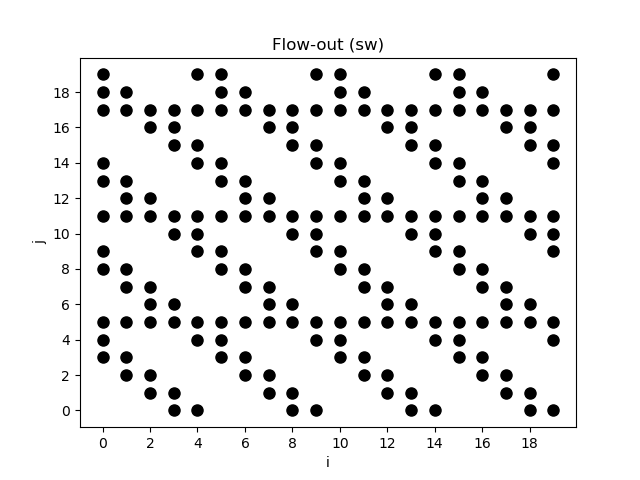

Tiling hyperplane with normal vector [1, 1] is legal
Tiling hyperplane with normal vector [0, 1] is legal
Consumer tile: [1, 0]
Consumer tile: [0]
Consumer tile: [1]
Done: 6 / 7

MARS:
  { [i, j] : (1 + 6i + j) mod 30 = 0 }
  { [i, j] : (1 + j) mod 6 = 0 and 5*floor((1 + i + j)/5) <= i + j and 5*floor((i + j)/5) <= -3 + i + j }
  { [i, j] : 6*floor((1 + j)/6) <= j and 30*floor((1 + 6i + j)/30) <= 6i + j and ((5*floor((i + j)/5) <= -3 + i + j) or (1 + i + j) mod 5 = 0) }
  { [i, j] : (1 + j) mod 6 = 0 and 5*floor((1 + i + j)/5) <= i + j and 30*floor((1 + 6i + j)/30) <= 6i + j and 5*floor((i + j)/5) >= -2 + i + j }



<IPython.core.display.Javascript object>


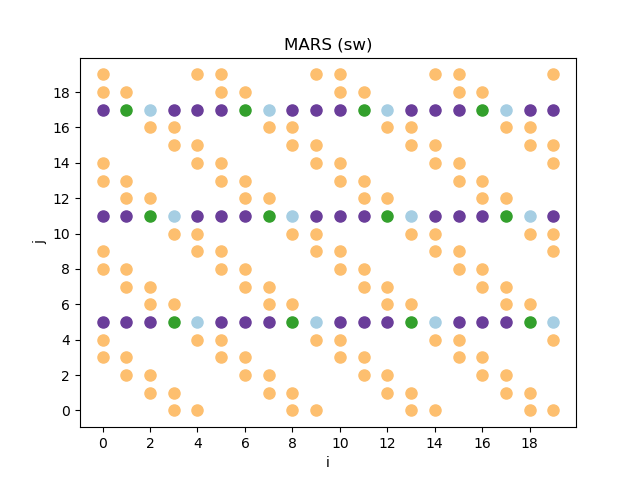

Text(0, 0.5, 'j')

In [4]:
# Smith-Waterman

# Definitions

Space = "[i, j]"
Ndims = 2
Dependences = [[1, 0], [0, 1], [1, 1]]
Hyperplanes = ["i + j", "j"]
TileSizes = [5, 6]
NormalVectors = [[1, 1], [0, 1]]
Dom = Set("{ [i, j] : 0 <= i < 20 and 0 <= j < 20 }")

if 'sw_flow_out' not in vars() and CheckTilingLegal(Dependences, NormalVectors):
    # Compute flow-out
    sw_flow_out = FlowOut(Space, Dependences, Hyperplanes, NormalVectors, TileSizes).copy().intersect(Dom.copy())

fig_sw_flowout = plt.figure()
islp.plot_set_points(sw_flow_out, size=8, color="#000000", marker="o")
fig_sw_flowout.get_axes()[0].set_title("Flow-out (sw)")
fig_sw_flowout.get_axes()[0].xaxis.set_major_locator(mticker.MultipleLocator(2))
fig_sw_flowout.get_axes()[0].yaxis.set_major_locator(mticker.MultipleLocator(2))
fig_sw_flowout.get_axes()[0].set_xlabel("i")
fig_sw_flowout.get_axes()[0].set_ylabel("j")

if 'sw_mars' not in vars() and CheckTilingLegal(Dependences, NormalVectors):
    # Compute and plot MARS
    sw_mars = MARS(Space, Dependences, Hyperplanes, NormalVectors, TileSizes)
    print("MARS:\n  " + "\n  ".join([str(i) for i in sw_mars]) + "\n")

colors = color_range(len(sw_mars))
fig_sw_mars = plt.figure()
for i in range(len(sw_mars)):
    M = sw_mars[i]
    c = colors[i]
    islp.plot_set_points(M.coalesce().intersect(Dom.copy()), size=8, color=c, marker="o")
fig_sw_mars.get_axes()[0].set_title("MARS (sw)")
fig_sw_mars.get_axes()[0].xaxis.set_major_locator(mticker.MultipleLocator(2))
fig_sw_mars.get_axes()[0].yaxis.set_major_locator(mticker.MultipleLocator(2))
fig_sw_mars.get_axes()[0].set_xlabel("i")
fig_sw_mars.get_axes()[0].set_ylabel("j")

Tiling hyperplane with normal vector [1, 1] is legal
Tiling hyperplane with normal vector [1, -1] is legal


<IPython.core.display.Javascript object>


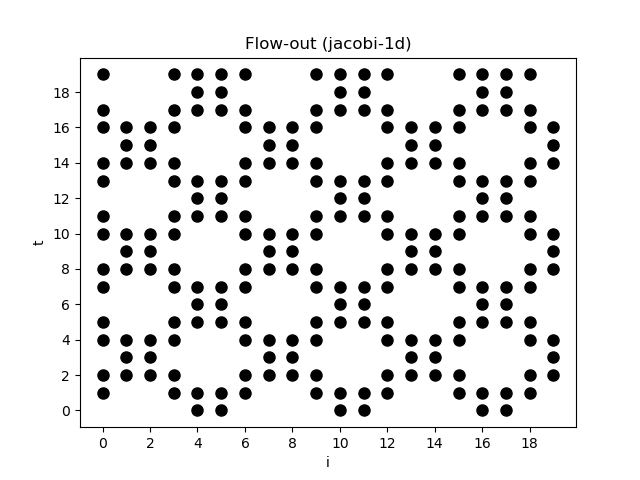

Tiling hyperplane with normal vector [1, 1] is legal
Tiling hyperplane with normal vector [1, -1] is legal
Consumer tile: [1, 0]
Consumer tile: [0]
Consumer tile: [1]
Done: 6 / 7

MARS:
  { [t, i] : (1 + t) mod 3 = 0 and (1 + t + i) mod 6 = 0 and 6*floor((t - i)/6) <= -4 + t - i and 6*floor((t + i)/6) <= -4 + t + i }
  { [t, i] : 6*floor((t - i)/6) <= -4 + t - i and 6*floor((t + i)/6) <= -4 + t + i and 6*floor((1 + t + i)/6) <= 2 + i + 3*floor((1 + t)/3) and 6*floor((1 + t + i)/6) <= 1 + 2t + i - 3*floor((1 + t)/3) }
  { [t, i] : 6*floor((t - i)/6) >= -3 + t - i and 6*floor((-1 - t + i)/6) <= -2 - t + i and ((6*floor((1 + t + i)/6) <= 2 + i + 3*floor((1 + t)/3) and 6*floor((1 + t + i)/6) <= 1 + 2t + i - 3*floor((1 + t)/3) and 6*floor((t + i)/6) <= -4 + t + i) or ((1 + t + i) mod 6 = 0 and -5 - t + i <= 6*floor((-1 - t + i)/6) <= -3 - t + i and 3*floor((1 + t)/3) <= t)) }
  { [t, i] : 6*floor((1 + t + i)/6) <= t + i and 6*floor((t + i)/6) >= -3 + t + i and ((6*floor((t - i)/6) <= -4 + t

<IPython.core.display.Javascript object>


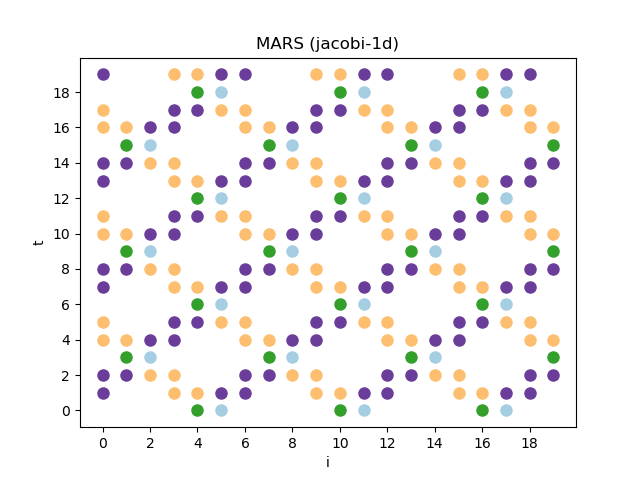

Text(0, 0.5, 't')

In [5]:
# Jacobi 1D

# Definitions

Space = "[t, i]"
Ndims = 2
Dependences = [[1, -1], [1, 0], [1, 1]]
Hyperplanes = ["t + i", "t - i"]
NormalVectors = [[1, 1], [1, -1]]
TileSizes = [6, 6]
Dom = Set("{ [t, i] : 0 <= t < 20 and 0 <= i < 20 }")

if 'jacobi1d_flow_out' not in vars() and CheckTilingLegal(Dependences, NormalVectors):
    # Compute flow-out
    jacobi1d_flow_out = FlowOut(Space, Dependences, Hyperplanes, NormalVectors, TileSizes).copy().intersect(Dom.copy())

fig_jacobi1d_flowout = plt.figure()
islp.plot_set_points(jacobi1d_flow_out, size=8, color="#000000", marker="o")
fig_jacobi1d_flowout.get_axes()[0].set_title("Flow-out (jacobi-1d)")
fig_jacobi1d_flowout.get_axes()[0].xaxis.set_major_locator(mticker.MultipleLocator(2))
fig_jacobi1d_flowout.get_axes()[0].yaxis.set_major_locator(mticker.MultipleLocator(2))
fig_jacobi1d_flowout.get_axes()[0].set_xlabel("i")
fig_jacobi1d_flowout.get_axes()[0].set_ylabel("t")

if 'jacobi1d_mars' not in vars() and CheckTilingLegal(Dependences, NormalVectors):
    # Compute and plot MARS
    jacobi1d_mars = MARS(Space, Dependences, Hyperplanes, NormalVectors, TileSizes)
    print("MARS:\n  " + "\n  ".join([str(i) for i in jacobi1d_mars]) + "\n")

colors = color_range(len(jacobi1d_mars))
fig_jacobi1d_mars = plt.figure()
for i in range(len(jacobi1d_mars)):
    M = jacobi1d_mars[i]
    c = colors[i]
    islp.plot_set_points(M.coalesce().intersect(Dom.copy()), size=8, color=c, marker="o")
fig_jacobi1d_mars.get_axes()[0].set_title("MARS (jacobi-1d)")
fig_jacobi1d_mars.get_axes()[0].xaxis.set_major_locator(mticker.MultipleLocator(2))
fig_jacobi1d_mars.get_axes()[0].yaxis.set_major_locator(mticker.MultipleLocator(2))
fig_jacobi1d_mars.get_axes()[0].set_xlabel("i")
fig_jacobi1d_mars.get_axes()[0].set_ylabel("t")

## 3D iteration spaces

The considered applications are `canonical3d`, `seidel2d`, `gemm`, `jacobi2d` (`-r` for rectangular tiling and `-d` for diamond tiling).

For each application, we compute the MARS and plot them for a single tile.

Tiling hyperplane with normal vector [1, 0, 0] is legal
Tiling hyperplane with normal vector [0, 1, 0] is legal
Tiling hyperplane with normal vector [0, 0, 1] is legal
Consumer tile: [0]
Consumer tile: [1]
Consumer tile: [2]
Done: 6 / 127

MARS:
  { [i, j, k] : (1 + i) mod 6 = 0 and (1 + j) mod 6 = 0 and (1 + k) mod 6 = 0 }
  { [i, j, k] : (1 + i) mod 6 = 0 and (1 + j) mod 6 = 0 and 6*floor((1 + k)/6) <= k }
  { [i, j, k] : (1 + i) mod 6 = 0 and (1 + k) mod 6 = 0 and 6*floor((1 + j)/6) <= j }
  { [i, j, k] : (1 + i) mod 6 = 0 and 6*floor((1 + j)/6) <= j and 6*floor((1 + k)/6) <= k }
  { [i, j, k] : (1 + j) mod 6 = 0 and (1 + k) mod 6 = 0 and 6*floor((1 + i)/6) <= i }
  { [i, j, k] : (1 + j) mod 6 = 0 and 6*floor((1 + i)/6) <= i and 6*floor((1 + k)/6) <= k }
  { [i, j, k] : (1 + k) mod 6 = 0 and 6*floor((1 + i)/6) <= i and 6*floor((1 + j)/6) <= j }



<IPython.core.display.Javascript object>


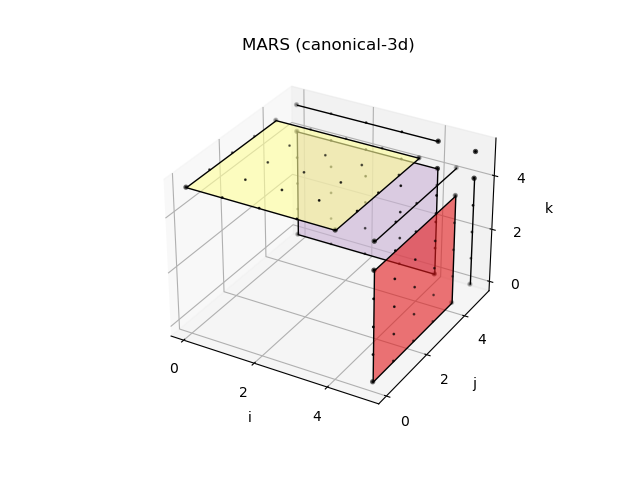

Text(0.5, 0, 'k')

In [6]:
# Canonical Deps 3D

# Definitions

Space = "[i, j, k]"
Ndims = 3
Dependences = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
Hyperplanes = ["i", "j", "k"]
NormalVectors = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
TileSizes = [6, 6, 6]

Dom = Set("{ [i, j, k] : 0 <= i < 10 and 0 <= j < 10 and 0 <= k < 10 }")
TileOfInterest = Set("{ [i, j, k] : 0 <= i < 6 and 0 <= j < 6 and 0 <= k < 6 }")

if 'canonical3d_mars' not in vars() and CheckTilingLegal(Dependences, NormalVectors):
    # Compute and plot MARS
    canonical3d_mars = MARS(Space, Dependences, Hyperplanes, NormalVectors, TileSizes)
    print("MARS:\n  " + "\n  ".join([str(i) for i in canonical3d_mars]) + "\n")

canonical3d_vis_transf = Map("{ [i, j, k] -> [i, j, k] }")
canonical3d_simpl_mars = [x .intersect(TileOfInterest.copy()).polyhedral_hull().apply(canonical3d_vis_transf.copy())
                       for x in canonical3d_mars]
# print("Simplified MARS:\n  " + "\n  ".join([str(i) for i in canonical3d_simpl_mars]))

colors = color_range(len(canonical3d_mars))
fig_canonical3d_mars = plot_set_3d(canonical3d_simpl_mars, fig=None, show_points=True, show_vertices=True, show_shape=True, face_colors=colors, alpha=0.6)
fig_canonical3d_mars.get_axes()[0].set_title("MARS (canonical-3d)")
fig_canonical3d_mars.get_axes()[0].xaxis.set_major_locator(mticker.MultipleLocator(2))
fig_canonical3d_mars.get_axes()[0].yaxis.set_major_locator(mticker.MultipleLocator(2))
fig_canonical3d_mars.get_axes()[0].zaxis.set_major_locator(mticker.MultipleLocator(2))
fig_canonical3d_mars.get_axes()[0].set_xlabel("i")
fig_canonical3d_mars.get_axes()[0].set_ylabel("j")
fig_canonical3d_mars.get_axes()[0].set_zlabel("k")

Tiling hyperplane with normal vector [1, 0, 0] is legal
Tiling hyperplane with normal vector [1, 1, 0] is legal
Tiling hyperplane with normal vector [4, 2, 1] is legal
Consumer tile: [2, 1, 0]
Consumer tile: [1, 0]
Consumer tile: [2, 0]
Consumer tile: [0]
Consumer tile: [2, 1]
Consumer tile: [1]
Consumer tile: [2]
Done: 126 / 127

MARS:
  { [t, i, j] : (1 + t) mod 4 = 0 and (1 + t + i) mod 10 = 0 and (-1 - t + 2j) mod 20 = 0 and 10*floor((1 + 4t + 2i + j)/10) <= 4t + 2i + j }
  { [t, i, j] : (1 + t) mod 4 = 0 and (1 + t + i) mod 10 = 0 and 10*floor((4t + 2i + j)/10) <= -7 + 4t + 2i + j and 10*floor((1 + 4t + 2i + j)/10) <= 4t + 2i + j }
  { [t, i, j] : (1 + t) mod 4 = 0 and (1 + t + i) mod 10 = 0 and (-7 - t + 2j) mod 20 = 0 }
  { [t, i, j] : (1 + t) mod 4 = 0 and (1 + t + i) mod 10 = 0 and 10*floor((1 + 4t + 2i + j)/10) <= 4t + 2i + j and 10*floor((4t + 2i + j)/10) >= -5 + 4t + 2i + j and 10*floor((-1 + 2t + j)/10) <= -2 + 2t + j and 10*floor((-4 - t + 2i + j)/10) <= -5 - t + 2i + j }

<IPython.core.display.Javascript object>


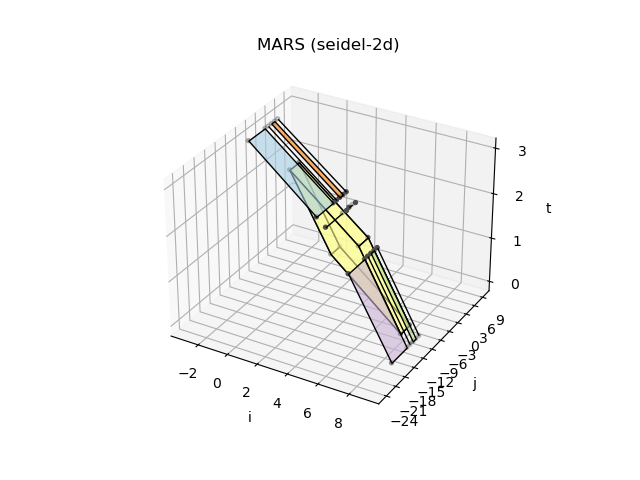

Text(0.5, 0, 't')

In [7]:
# Seidel 2D

# Definitions

Space = "[t, i, j]"
Ndims = 3
Dependences = [[0, 1, 1], [0, 0, 1], [1, -1, 1], 
               [0, 1, 0], [1, 0, 0], [1, -1, 0], 
               [0, 1, -1], [1, 0, -1], [1, -1,-1]]
Hyperplanes = ["t", "t + i", "4t + 2i + j"]
NormalVectors = [[1, 0, 0], [1, 1, 0], [4, 2, 1]]
TileSizes = [4, 10, 10]

Dom = Set("{ [t, i, j] : 0 <= t < 30 and 0 <= i < 30 and 0 <= j < 30 }")
TileOfInterest = Set("{ [t, i, j] : 0 <= t + i < 10 and 0 <= t < 4 and 0 <= 4t + 2i + j < 10 }")

if 'seidel2d_mars' not in vars() and CheckTilingLegal(Dependences, NormalVectors):
    # Compute and plot MARS
    seidel2d_mars = MARS(Space, Dependences, Hyperplanes, NormalVectors, TileSizes)
    print("MARS:\n  " + "\n  ".join([str(i) for i in seidel2d_mars]) + "\n")
    
# Uncomment to get each MARS's cardinality
# seidel2d_mars_card = [x.copy().intersect(TileOfInterest.copy()).count_val() for x in seidel2d_mars]
# print(seidel2d_mars_card)

seidel2d_vis_transf = Map("{ [t, i, j] -> [i, j, t] }")
seidel2d_simpl_mars = [x.coalesce().intersect(TileOfInterest.copy()).polyhedral_hull().apply(seidel2d_vis_transf.copy())
                       for x in seidel2d_mars]
# print("Simplified MARS:\n  " + "\n  ".join([str(i) for i in seidel2d_simpl_mars]))

colors = color_range(len(seidel2d_mars))
fig_seidel2d_mars = plot_set_3d(seidel2d_simpl_mars, fig=None, show_points=False, 
                                show_vertices=True, show_shape=True, face_colors=colors, alpha=0.6)
fig_seidel2d_mars.get_axes()[0].set_title("MARS (seidel-2d)")
fig_seidel2d_mars.get_axes()[0].xaxis.set_major_locator(mticker.MultipleLocator(2))
fig_seidel2d_mars.get_axes()[0].yaxis.set_major_locator(mticker.MultipleLocator(3))
fig_seidel2d_mars.get_axes()[0].zaxis.set_major_locator(mticker.MultipleLocator(1))
fig_seidel2d_mars.get_axes()[0].set_xlabel("i")
fig_seidel2d_mars.get_axes()[0].set_ylabel("j")
fig_seidel2d_mars.get_axes()[0].set_zlabel("t")

Tiling hyperplane with normal vector [1, 0, 0] is legal
Tiling hyperplane with normal vector [0, 0, 1] is legal
Tiling hyperplane with normal vector [0, 1, 0] is legal
Consumer tile: [2]
Done: 0 / 127

MARS:
  { [i, k, j] : (1 + k) mod 10 = 0 }



<IPython.core.display.Javascript object>


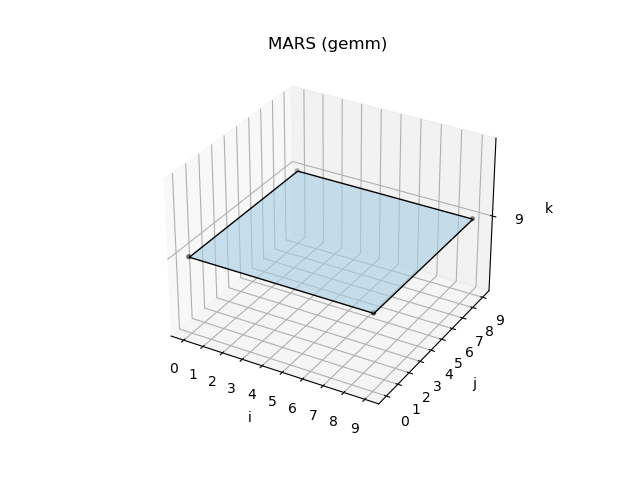

Text(0.5, 0, 'k')

In [8]:
# GEMM

# Definitions

Space = "[i, k, j]"
Ndims = 3
Dependences = [[0, 1, 0]]
Hyperplanes = ["i", "j", "k"]
NormalVectors = [[1, 0, 0], [0, 0, 1], [0, 1, 0]]

TileSizes = [10, 10, 10]
Dom = Set("{ [i, k, j] : 0 <= i < 30 and 0 <= k < 30 and 0 <= j < 30 }")
TileOfInterest = Set("{ [i, k, j] : 0 <= i < 10 and 0 <= k < 10 and 0 <= j < 10 }")

if 'gemm_mars' not in vars() and CheckTilingLegal(Dependences, NormalVectors):
    # Compute and plot MARS
    gemm_mars = MARS(Space, Dependences, Hyperplanes, NormalVectors, TileSizes)
    print("MARS:\n  " + "\n  ".join([str(i) for i in gemm_mars]) + "\n")
    
# Uncomment to get each MARS's cardinality
# gemm_mars_card = [x.copy().intersect(TileOfInterest.copy()).count_val() for x in gemm_mars]
# print(gemm_mars_card)

gemm_vis_transf = Map("{ [i, k, j] -> [i, j, k] }")
gemm_simpl_mars = [x.coalesce().intersect(TileOfInterest.copy()).polyhedral_hull().apply(gemm_vis_transf.copy())
                       for x in gemm_mars]
# print("Simplified MARS:\n  " + "\n  ".join([str(i) for i in gemm_simpl_mars]))

colors = color_range(len(gemm_mars))
fig_gemm_mars = plot_set_3d(gemm_simpl_mars, fig=None, show_points=False, 
                                show_vertices=True, show_shape=True, face_colors=colors, alpha=0.6)
fig_gemm_mars.get_axes()[0].set_title("MARS (gemm)")
fig_gemm_mars.get_axes()[0].xaxis.set_major_locator(mticker.MultipleLocator(1))
fig_gemm_mars.get_axes()[0].yaxis.set_major_locator(mticker.MultipleLocator(1))
fig_gemm_mars.get_axes()[0].zaxis.set_major_locator(mticker.MultipleLocator(1))
fig_gemm_mars.get_axes()[0].set_xlabel("i")
fig_gemm_mars.get_axes()[0].set_ylabel("j")
fig_gemm_mars.get_axes()[0].set_zlabel("k")

Tiling hyperplane with normal vector [1, 0, 0] is legal
Tiling hyperplane with normal vector [1, 1, 0] is legal
Tiling hyperplane with normal vector [1, 0, 1] is legal
Consumer tile: [2, 1, 0]
Consumer tile: [1, 0]
Consumer tile: [2, 0]
Consumer tile: [0]
Consumer tile: [2, 1]
Consumer tile: [1]
Consumer tile: [2]
Done: 126 / 127

MARS:
  { [t, i, j] : (1 + t) mod 10 = 0 and (i) mod 10 = 0 and (j) mod 10 = 0 }
  { [t, i, j] : (1 + t) mod 10 = 0 and (i) mod 10 = 0 and 10*floor((t + j)/10) <= -8 + t + j and 10*floor((1 + t + j)/10) <= t + j and 10*floor((j)/10) < j }
  { [t, i, j] : (1 + t) mod 10 = 0 and (j) mod 10 = 0 and 10*floor((t + i)/10) <= -8 + t + i and 10*floor((1 + t + i)/10) <= t + i and 10*floor((i)/10) < i }
  { [t, i, j] : (1 + t) mod 10 = 0 and 10*floor((1 + t + i)/10) <= t + i and 10*floor((t + j)/10) <= -8 + t + j and 10*floor((t + i)/10) <= -8 + t + i and 10*floor((1 + t + j)/10) <= t + j and 10*floor((i)/10) < i and 10*floor((j)/10) < j }
  { [t, i, j] : (1 + t) mod 1

<IPython.core.display.Javascript object>


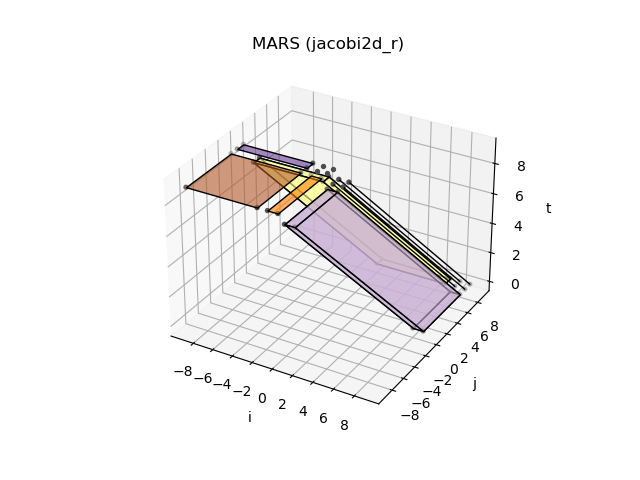

Text(0.5, 0, 't')

In [9]:
# Jacobi 2D

# Definitions
Space = "[t, i, j]"
Ndims = 3
Dependences = [[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, -1, 0], [1, 0, -1]]
Hyperplanes = ["t", "t+i", "t+j"]
NormalVectors = [[1, 0, 0], [1, 1, 0], [1, 0, 1]]
TileSizes = [10, 10, 10]
   
Dom = Set("{ [i0, i1, i2] : 0 <= i0 <= 399 and 0 < i1 <= 498 and 0 < i2 <= 498 and (((1 + i0) mod 2 = 0 and i0 > 0) or ((i0) mod 2 = 0 and i0 <= 398)) }")
TileOfInterest = Set("{ [t, i, j] : 0 <= t < 10 and 0 <= t+i < 10 and 0 <= t+j < 10 }")

if 'jacobi2d_r_mars' not in vars() and CheckTilingLegal(Dependences, NormalVectors):
    # Compute and plot MARS
    jacobi2d_r_mars = MARS(Space, Dependences, Hyperplanes, NormalVectors, TileSizes)
    print("MARS:\n  " + "\n  ".join([str(i) for i in jacobi2d_r_mars]) + "\n")
    
# Uncomment to get each MARS's cardinality
# jacobi2d_r_mars_card = [x.copy().intersect(TileOfInterest.copy()).count_val() for x in jacobi2d_r_mars]
# print(jacobi2d_r_mars_card)
    
jacobi2d_r_vis_transf = Map("{ [t, i, j] -> [i, j, t] }")
jacobi2d_r_simpl_mars = [x.coalesce().intersect(TileOfInterest.copy()).polyhedral_hull().apply(jacobi2d_r_vis_transf.copy())
                       for x in jacobi2d_r_mars]
# print("Simplified MARS:\n  " + "\n  ".join([str(i) for i in jacobi2d_r_simpl_mars]))

colors = color_range(len(jacobi2d_r_mars))
fig_jacobi2d_r_mars = plot_set_3d(jacobi2d_r_simpl_mars, fig=None, show_points=False, 
                                show_vertices=True, show_shape=True, face_colors=colors, alpha=0.6)
fig_jacobi2d_r_mars.get_axes()[0].set_title("MARS (jacobi2d_r)")
fig_jacobi2d_r_mars.get_axes()[0].xaxis.set_major_locator(mticker.MultipleLocator(2))
fig_jacobi2d_r_mars.get_axes()[0].yaxis.set_major_locator(mticker.MultipleLocator(2))
fig_jacobi2d_r_mars.get_axes()[0].zaxis.set_major_locator(mticker.MultipleLocator(2))
fig_jacobi2d_r_mars.get_axes()[0].set_xlabel("i")
fig_jacobi2d_r_mars.get_axes()[0].set_ylabel("j")
fig_jacobi2d_r_mars.get_axes()[0].set_zlabel("t")

Tiling hyperplane with normal vector [1, 1, 0] is legal
Tiling hyperplane with normal vector [1, 0, 1] is legal
Tiling hyperplane with normal vector [1, -1, 0] is legal
Tiling hyperplane with normal vector [1, 0, -1] is legal
Consumer tile: [3, 2, 1, 0]
Consumer tile: [2, 1, 0]
Consumer tile: [3, 1, 0]
Consumer tile: [1, 0]
Consumer tile: [3, 2, 0]
Consumer tile: [2, 0]
Consumer tile: [3, 0]
Consumer tile: [0]
Consumer tile: [3, 2, 1]
Consumer tile: [2, 1]
Consumer tile: [3, 1]
Consumer tile: [1]
Consumer tile: [3, 2]
Consumer tile: [2]
Consumer tile: [3]
Done: 32766 / 32767

MARS:
  { [t, i, j] : (1 + t) mod 5 = 0 and (1 + t + i) mod 10 = 0 and (1 + t + j) mod 10 = 0 and 10*floor((t - i)/10) <= -8 + t - i and 10*floor((t + i)/10) <= -8 + t + i and 10*floor((t + j)/10) <= -8 + t + j }
  { [t, i, j] : (1 + t) mod 5 = 0 and (1 + t + i) mod 10 = 0 and 10*floor((-1 - t + j)/10) <= -2 - t + j and 10*floor((1 + t + j)/10) <= t + j and 10*floor((t + j)/10) <= -8 + t + j and 10*floor((t - j)/1

<IPython.core.display.Javascript object>


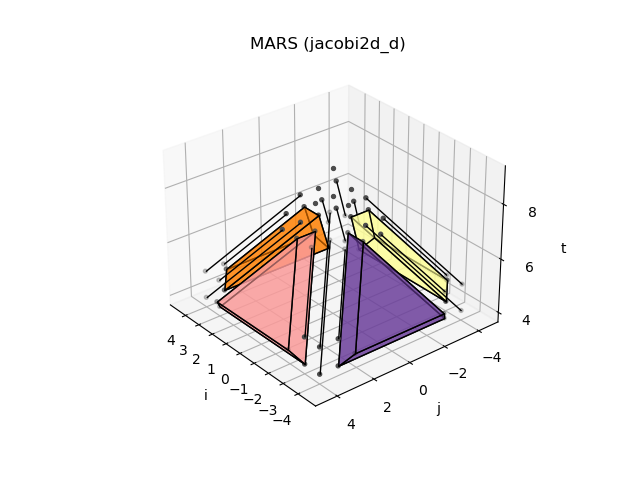

Text(0.5, 0, 't')

In [10]:
# Jacobi 2D, diamond tiling

# Definitions

Space = "[t, i, j]"
Ndims = 3
Dependences = [[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, -1, 0], [1, 0, -1]]
Hyperplanes = ["t+i", "t+j", "t-i", "t-j"]
NormalVectors = [[1, 1, 0], [1, 0, 1], [1, -1, 0], [1, 0, -1]]
TileSizes = [10, 10, 10, 10]

Dom = Set("{ [i0, i1, i2] : 0 <= i0 <= 399 and 0 < i1 <= 498 and 0 < i2 <= 498 and (((1 + i0) mod 2 = 0 and i0 > 0) or ((i0) mod 2 = 0 and i0 <= 398)) }")
TileOfInterest = Set("{ [t, i, j] : 0 <= t+i < 10 and 0 <= t+j < 10 and 0 <= t-i < 10 and 0 <= t-j < 10 }")

if 'jacobi2d_d_mars' not in vars() and CheckTilingLegal(Dependences, NormalVectors):
    # Compute and plot MARS
    jacobi2d_d_mars = MARS(Space, Dependences, Hyperplanes, NormalVectors, TileSizes)
    print("MARS:\n  " + "\n  ".join([str(i) for i in jacobi2d_d_mars]) + "\n")
    
# Uncomment to get each MARS's cardinality
# jacobi2d_d_mars_card = [x.copy().intersect(TileOfInterest.copy()).count_val() for x in jacobi2d_d_mars]
# print(jacobi2d_d_mars_card)

jacobi2d_d_vis_transf = Map("{ [t, i, j] -> [i, j, t] }")
jacobi2d_d_simpl_mars = [x.coalesce().intersect(TileOfInterest.copy()).polyhedral_hull().apply(jacobi2d_d_vis_transf.copy())
                       for x in jacobi2d_d_mars]
# print("Simplified MARS:\n  " + "\n  ".join([str(i) for i in jacobi2d_d_simpl_mars]))
colors = color_range(len(jacobi2d_d_mars))
fig_jacobi2d_d_mars = plot_set_3d(jacobi2d_d_simpl_mars, fig=None, show_points=False, 
                                show_vertices=True, show_shape=True, face_colors=colors, alpha=0.6)
fig_jacobi2d_d_mars.get_axes()[0].set_title("MARS (jacobi2d_d)")
fig_jacobi2d_d_mars.get_axes()[0].xaxis.set_major_locator(mticker.MultipleLocator(1))
fig_jacobi2d_d_mars.get_axes()[0].yaxis.set_major_locator(mticker.MultipleLocator(2))
fig_jacobi2d_d_mars.get_axes()[0].zaxis.set_major_locator(mticker.MultipleLocator(2))
fig_jacobi2d_d_mars.get_axes()[0].set_xlabel("i")
fig_jacobi2d_d_mars.get_axes()[0].set_ylabel("j")
fig_jacobi2d_d_mars.get_axes()[0].set_zlabel("t")

# Figure output

The figures can be saved after manipulation by turning `save_figs` to `True` in the code below.

In [11]:
save_figs = False

if save_figs:
    fig_sw_mars.savefig("mars-sw.pdf")
    fig_jacobi1d_mars.savefig("mars-jacobi1d.pdf")
    fig_canonical3d_mars.savefig("mars-canonical3d.pdf")
    fig_seidel2d_mars.savefig("mars-seidel2d.pdf")
    fig_gemm_mars.savefig("mars-gemm.pdf")
    fig_jacobi2d_r_mars.savefig("mars-jacobi2d-r.pdf")
    fig_jacobi2d_d_mars.savefig("mars-jacobi2d-d.pdf")